In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import glob
import math
import random
import time
import umap
from scipy.stats import poisson

In [2]:
df=pd.read_csv("Optimal data set.csv")

In [3]:
df=df.set_index("Feature")

In [4]:
df.drop(["Unnamed: 0"], axis='columns', inplace=True)

In [5]:
df=df.T

Data is colored by organs, by information of metadata.

In [6]:
List_of_optimal=pd.read_csv("List of optimal dataset.csv")

In [7]:
List_Of_OPT_metadata=[List_of_optimal['0'][i].replace("data","metadata") for i in range(0,168)]

In [8]:
OrgansC=[pd.read_csv(f"/Users/farhadzare/Desktop/Endotheliom/metadata/{List_Of_OPT_metadata[i]}", encoding='latin1')['Organ'] for i in range(0,168)]


In [9]:
OrgansCc=[]
for i in range(0,168):
    for j in range(0,len(OrgansC[i])):
        OrgansCc.append(OrgansC[i][j])

The number of colors is limited, if they are less than 50. 

In [10]:
Small_Num_g=[]
number=0
for i in set(OrgansCc):
     if OrgansCc.count(f'{i}')<50:
        print(i,OrgansCc.count(f'{i}'))
        Small_Num_g.append(i)
        number+=OrgansCc.count(f'{i}')

Somatic cell hybrid 12
Peripheral blood 24
Blood vessel 12
Brain 34
Bone marrow 4
Iliac artery 2
Colon 8
Intestine 48
Placenta 19
Lymphatic system 27
Breast 6
Iliac vein 3
Bone 43
Umbilical cord blood 41
Microvasculature 6
Uterus 10
Prostate 5
Kidney 14


In [11]:
for i in range(0,len(OrgansCc)):
    if OrgansCc[i] in Small_Num_g:
        OrgansCc[i]='Others'

In [12]:
#
# define function for quantile normalization
#
#"Quantile normalization consists on sorting, averaging and re-ordering."
#  "For more information: https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/"

def quantile_normalize(df):
    """
    input: dataframe with numerical columns
    output: dataframe with quantile normalized values
    """
    df_sorted = pd.DataFrame(np.sort(df.values,
                                     axis=0), 
                             index=df.index, 
                             columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return(df_qn)

In [13]:
dfq=quantile_normalize(df)

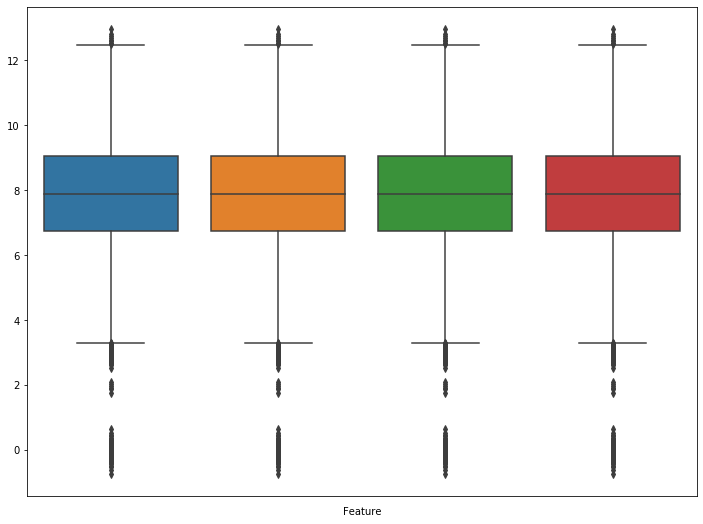

In [14]:
plt.figure(figsize=(12, 9))
g = sns.boxplot(data=dfq.iloc[:,1:5], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)

In [46]:
min(dfq.iloc[:,1])

-0.7372520152123688

Reduce variables by TSNE

In [15]:
from sklearn.manifold import TSNE

In [37]:
m=TSNE(learning_rate=150,n_iter=4000,perplexity=60, random_state=0, verbose=2)

In [38]:
tsne_features=m.fit_transform(dfq)

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 2636 samples in 0.009s...
[t-SNE] Computed neighbors for 2636 samples in 0.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2636
[t-SNE] Computed conditional probabilities for sample 2000 / 2636
[t-SNE] Computed conditional probabilities for sample 2636 / 2636
[t-SNE] Mean sigma: 12.068058
[t-SNE] Computed conditional probabilities in 0.181s
[t-SNE] Iteration 50: error = 70.5369415, gradient norm = 0.1016012 (50 iterations in 0.525s)
[t-SNE] Iteration 100: error = 62.0568695, gradient norm = 0.0081313 (50 iterations in 0.417s)
[t-SNE] Iteration 150: error = 61.1156540, gradient norm = 0.0058841 (50 iterations in 0.396s)
[t-SNE] Iteration 200: error = 60.8301048, gradient norm = 0.0034764 (50 iterations in 0.394s)
[t-SNE] Iteration 250: error = 60.6998863, gradient norm = 0.0019422 (50 iterations in 0.391s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.699886
[t-SNE] Iteration 300: er

In [39]:
tsne_features=pd.DataFrame(tsne_features,columns=['P1','P2'])

In [40]:
tsne_features["Organ"]=OrgansCc

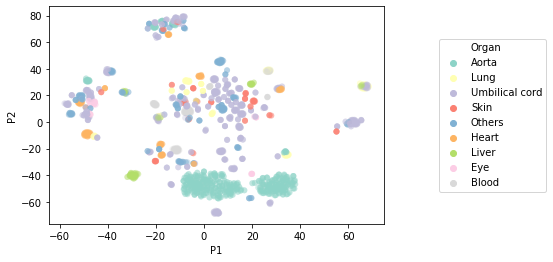

In [46]:
g=sns.scatterplot(x='P1',y='P2',data=tsne_features,hue="Organ", palette="Set3", linewidth=0, alpha=1/3)
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
plt.savefig(f'tesne after quantile.pdf')
plt.show()

Reduce variables by Umap

In [43]:
embedding=[]
for i in range(30,330,30):
    for j in ['cosine','correlation']:
        reducer = umap.UMAP(n_neighbors=i, min_dist=0.0, metric=j)
        embedding1 = reducer.fit_transform(dfq)
        embedding1=pd.DataFrame(embedding1,columns=["Umap_1","Umap_2"])
        embedding1["Organ"]=OrgansCc
        embedding.append(embedding1)
        time.sleep(10)


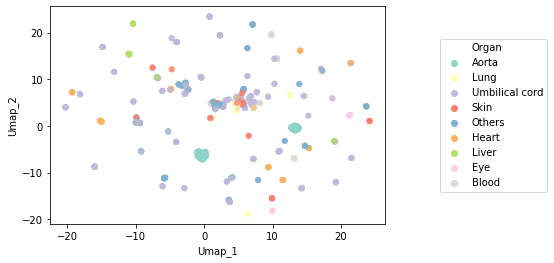

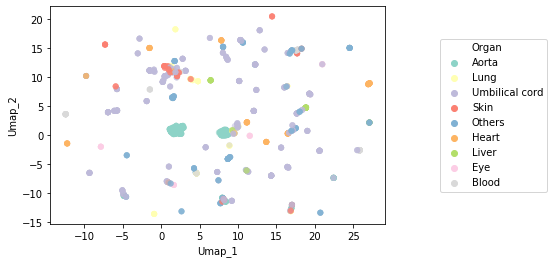

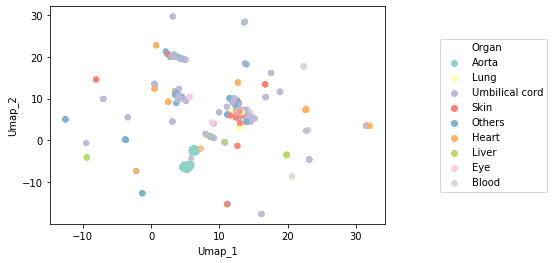

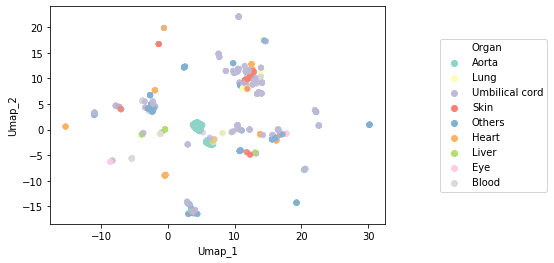

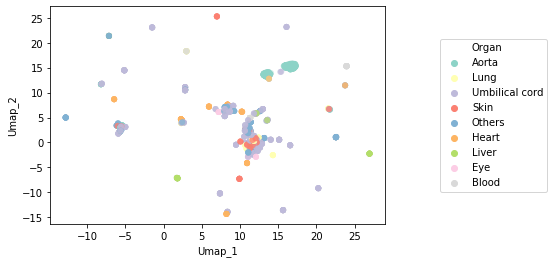

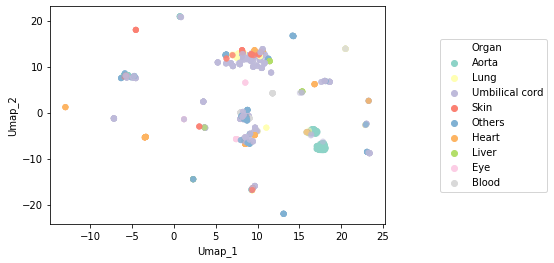

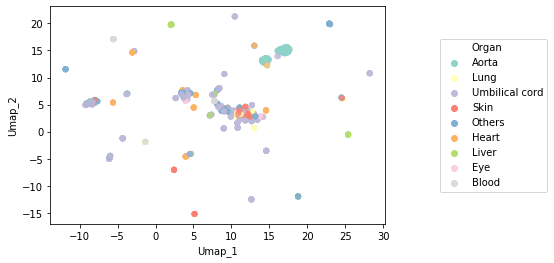

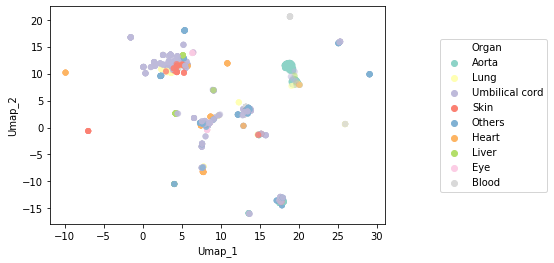

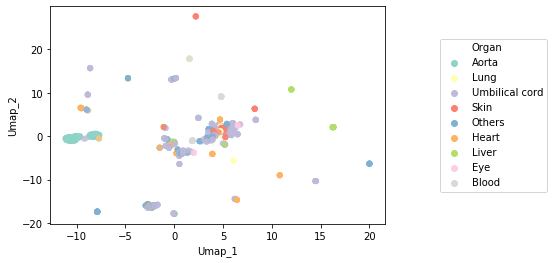

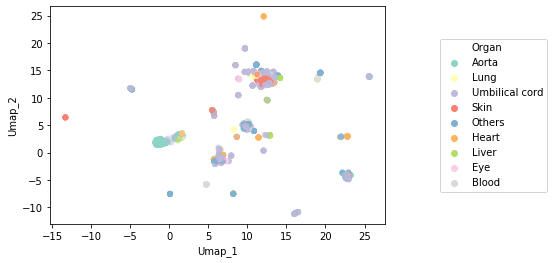

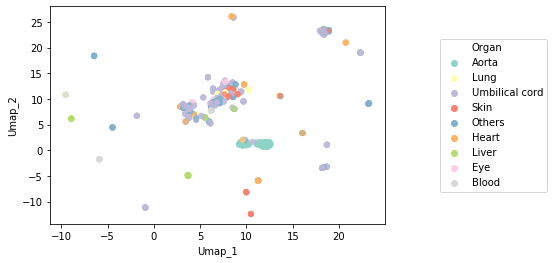

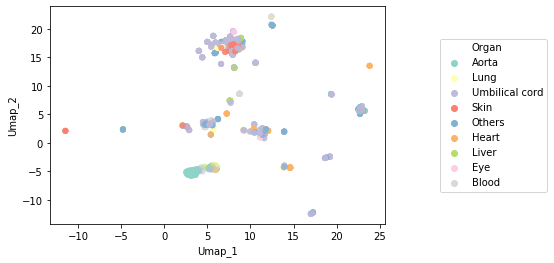

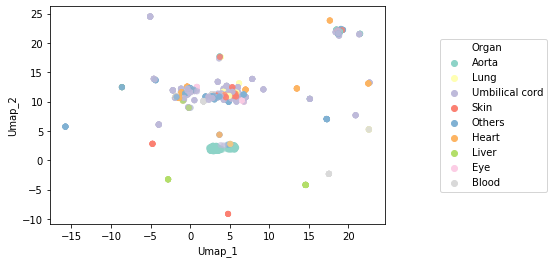

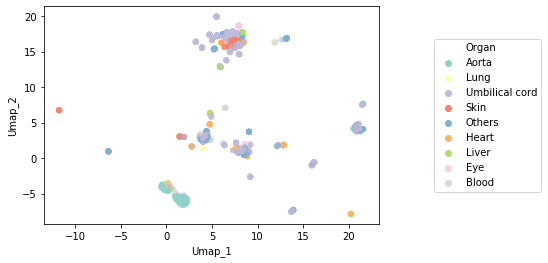

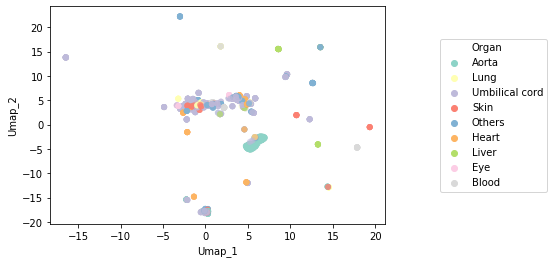

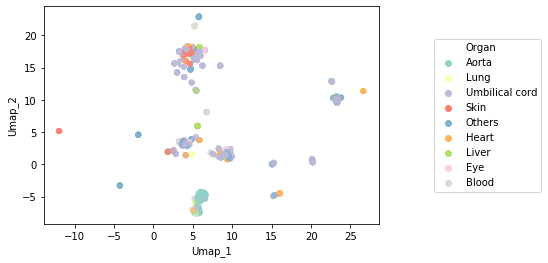

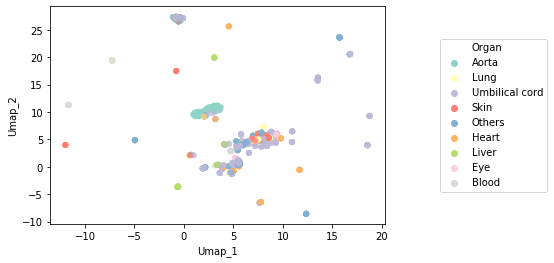

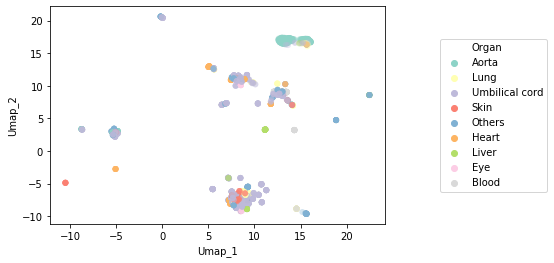

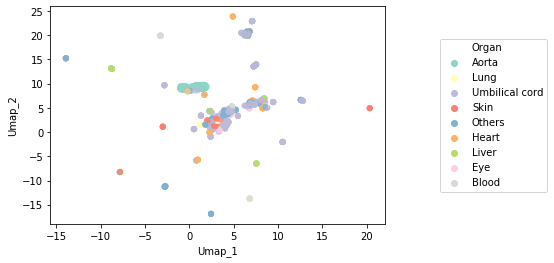

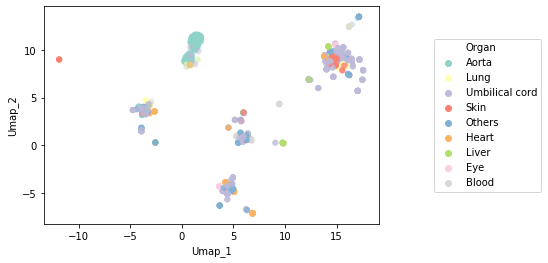

In [47]:
for i in range(0,20):
    g=sns.scatterplot(x="Umap_1", y="Umap_2",data=embedding[i],hue="Organ", palette="Set3", linewidth=0, alpha=1/3)
    g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
    plt.savefig(f'Umap{i}.pdf')
    plt.show()

PCA

In [48]:
from sklearn.decomposition import PCA

In [49]:
from sklearn import preprocessing

In [50]:
scaled_data=preprocessing.scale(dfq)

In [51]:
pca=PCA(n_components=2)

In [52]:
pca.fit(scaled_data)

PCA(n_components=2)

In [53]:
pca_data=pca.transform(scaled_data)

In [54]:
per_var=np.round(pca.explained_variance_ratio_*100,decimals=1)
labels=['Pc'+ str(x) for x in range(1,len(per_var)+1)]

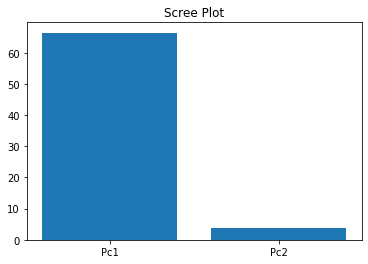

In [55]:
plt.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labels)
plt.title("Scree Plot")
plt.show()

In [56]:
principalDf = pd.DataFrame(data = pca_data, columns = ['principal component 1', 'principal component 2'])

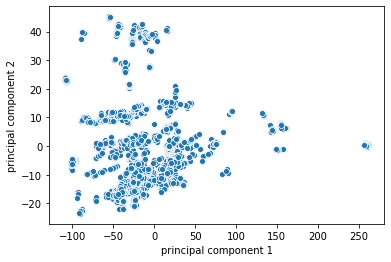

In [57]:
sns.scatterplot('principal component 1', 'principal component 2',data=principalDf)
plt.show()

Coefficient of variation 

In [16]:
import scipy.stats as sp

In [17]:
CV=dfq.apply(sp.variation)

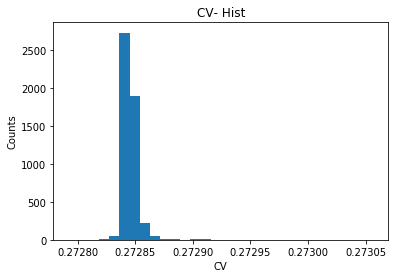

In [56]:
plt.hist(CV,bins=30)
plt.title('CV- Hist')
plt.ylabel('Counts')
plt.xlabel('CV')
plt.savefig('CV-Hist After Quantile.pdf')

In [20]:
CVf=df.apply(sp.variation)

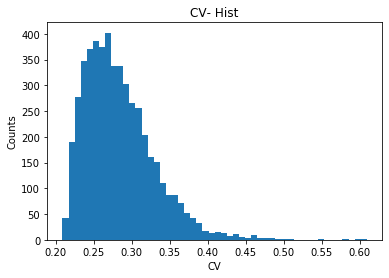

In [52]:
plt.hist(CVf,bins=50)
plt.title('CV- Hist')
plt.ylabel('Counts')
plt.xlabel('CV')
plt.savefig('CV-Hist befor Quantile.pdf')

In [31]:
min(CV)

0.2727923040852987

In [32]:
max(CV)

0.2730563418063979

In [33]:
min(CVf)

0.20887568747775442

In [34]:
max(CVf)

0.609586317737457

Finding the best Umap

In [37]:
embedding=[]
for i in range(200,400,30):
        reducer = umap.UMAP(n_neighbors=i, min_dist=0.0, metric='correlation')
        embedding1 = reducer.fit_transform(dfq)
        embedding1=pd.DataFrame(embedding1,columns=["Umap_1","Umap_2"])
        embedding1["Organ"]=OrgansCc
        embedding.append(embedding1)
        time.sleep(10)

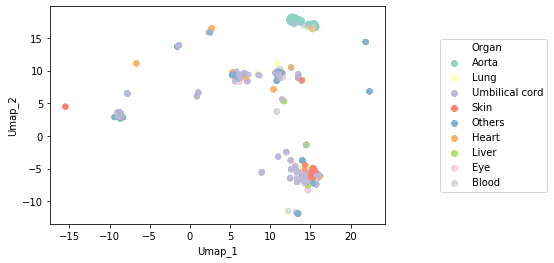

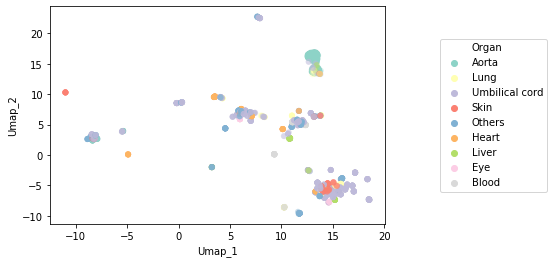

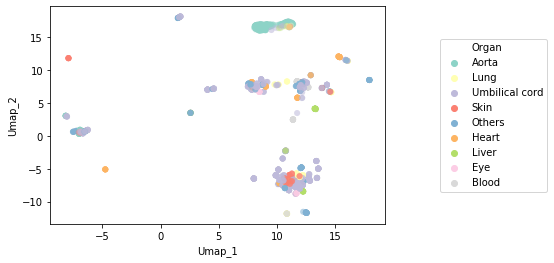

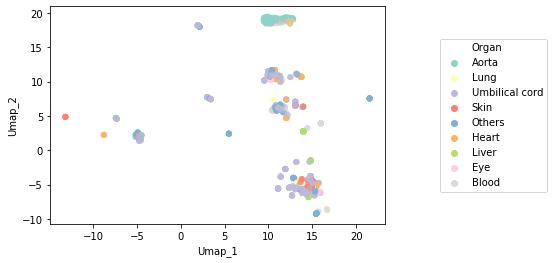

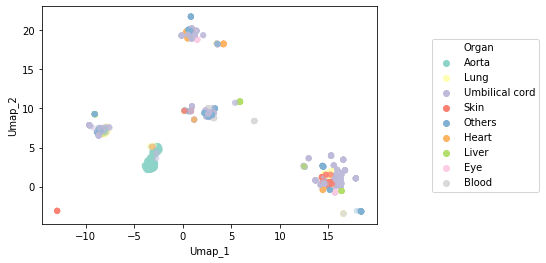

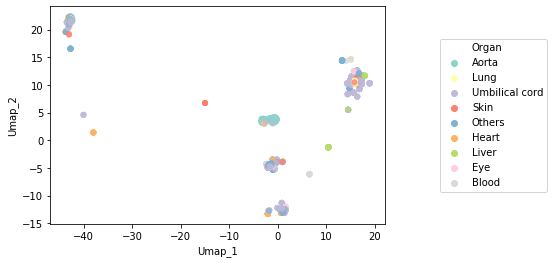

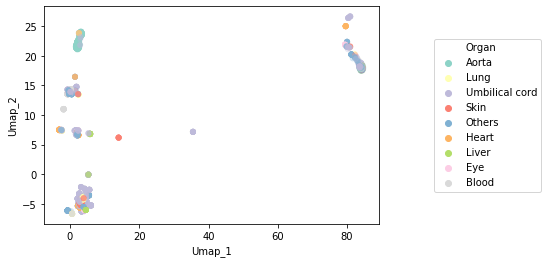

In [38]:
for i in range(0,7):
    g=sns.scatterplot(x="Umap_1", y="Umap_2",data=embedding[i],hue="Organ", palette="Set3", linewidth=0, alpha=1/3)
    g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
    plt.savefig(f'Umap{i}.pdf')
    plt.show()

In [38]:
reducer = umap.UMAP(n_neighbors=320, min_dist=0.0, metric='correlation')
embedding1 = reducer.fit_transform(dfq)
embedding1=pd.DataFrame(embedding1,columns=["Umap_1","Umap_2"])
embedding1["Organ"]=OrgansCc

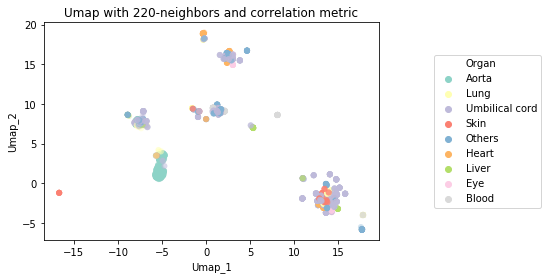

In [40]:
g=sns.scatterplot(x="Umap_1", y="Umap_2",data=embedding1,hue="Organ", palette="Set3", linewidth=0, alpha=1/3)
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
plt.title("Umap with 220-neighbors and correlation metric")
plt.savefig(f'Umap with 320-neighbors.pdf')
plt.show()